In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler

In [2]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, MaxAbsScaler

train_data = np.genfromtxt('/content/gdrive/MyDrive/PhD training/NSL-KDD/NSLKDD_Train.csv', dtype=np.float32, delimiter=',')
test_data  = np.genfromtxt('/content/gdrive/MyDrive/PhD training/NSL-KDD/NSLKDD_Test.csv', dtype=np.float32, delimiter=',')
print(train_data.shape)
print(test_data.shape)

(125973, 123)
(22544, 123)


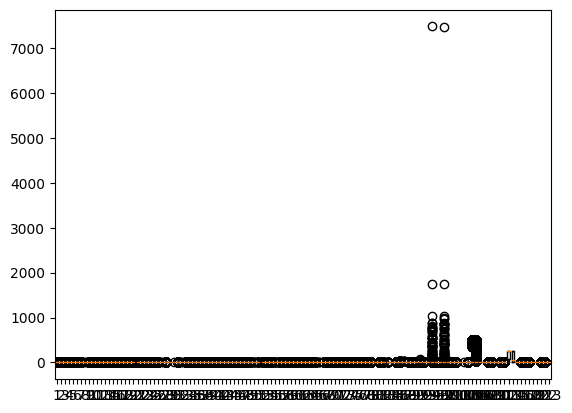

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(train_data)
plt.show()


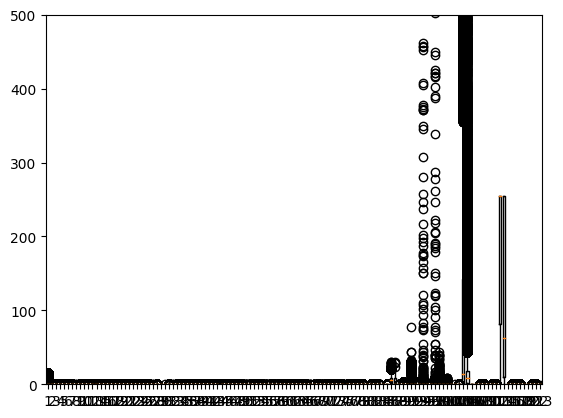

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(train_data)
# Set y-axis limits to zoom in
ax.set_ylim([0, 500])
# Show plot
plt.show()

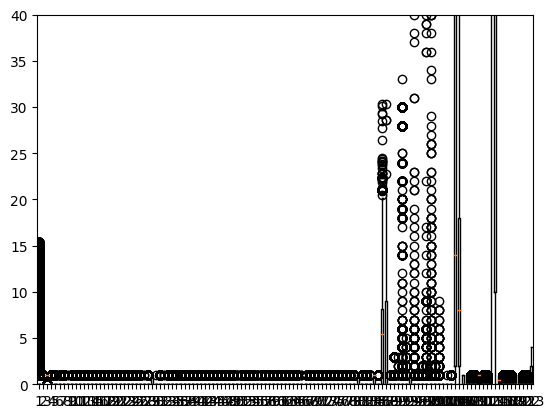

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(train_data)
# Set y-axis limits to zoom in
ax.set_ylim([0, 40])
# Show plot
plt.show()

Train: 67343 normal (0), 11656 Probe (1), 45927 DoS (2), 995 R2L (3), 52 U2R (4) 

Test:  9711 normal (0),   2421 Probe (1),   7458  DoS (2), 2887 R2L (3), 67 U2R (4) 

In [5]:
# Define the log transformer function
log_transformer = FunctionTransformer(lambda x: np.log(x + 1))

# Define the pipeline with log transformation and max absolute scaling
pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('max_abs_scaler', MaxAbsScaler())
])

In [6]:
#from sklearn.preprocessing import RobustScaler
#scaler = RobustScaler()

#create training data with normal and attack type exclude U2R
train_data_not_u2r= train_data[(train_data[:, -1] != 4)]
print(train_data_not_u2r.shape)
# With the train data, we Apply the pipeline to the data excluding the last column
train_norm = pipeline.fit_transform(train_data_not_u2r[:,:-1])

#train_norm = scaler.fit_transform(train_data_not_u2r[:,:-1])
# Create a new label based on the last column of the data, 0 to 1 and other to -1
new_label = np.where(train_data_not_u2r[:,-1] == 0, 1, -1)

# Append the new label to the transformed data
train_data_normalized = np.hstack((train_norm, new_label[:,np.newaxis]))
np.random.shuffle(train_data_normalized)

(125921, 123)


In [ ]:
print(np.count_nonzero(train_data_normalized[:, -1] == -1))

58578


In [7]:
#Append the U2R samples from training data into test data
u2r_from_train = train_data[train_data[:, -1]==4]
test_data = np.concatenate((test_data, u2r_from_train), axis=0)
#Apply preprocessing with testdata
test_norm = pipeline.transform(test_data[:,:-1])
#test_norm = scaler.transform(test_data[:,:-1])

#test_norm = pipeline.transform(test_data[:,:-1])
#Append the label into the transformed test data
test_data_normalized_include_old_label = np.hstack((test_norm, test_data[:,-1][:,np.newaxis]))

#We select  normal and U2R records only 
test_data_u2r = test_data_normalized_include_old_label[(test_data_normalized_include_old_label[:,-1] == 0) | (test_data_normalized_include_old_label[:,-1] == 4)]
np.random.shuffle(test_data_u2r)
print(test_data_u2r.shape)

# Create a new label based on the last column of the data, 0 to 1 and other to -1
new_label_test = np.where(test_data_u2r[:,-1] == 0, 1, -1)
y_test = new_label_test
# Replace the last column of the data with the new label
test_data_u2r[:,-1] = new_label_test
x_test = test_data_u2r

# -> we have the test data with normal and ur2 records, label 1 and -1
#select support test data with 200 sample normal and 10 sample u2r
positive_samples = x_test[x_test[:, -1] == 1][:200]
negative_samples = x_test[x_test[:, -1] == -1][:20]
support_test = np.concatenate([positive_samples, negative_samples])

# Get the rest of x_test as query data
b_indices = np.where((x_test == support_test[:,None]).all(-1))[1]
c_indices = np.setdiff1d(np.arange(x_test.shape[0]), b_indices)
query_test = x_test[c_indices, :]

#query_test = np.delete(x_test, support_test, axis=0)
print(support_test.shape)
print(query_test.shape)
#print(query_test.shape)

count_u2r_support = np.count_nonzero(support_test[:, -1] == -1)
print(count_u2r_support)
count_u2r_query = np.count_nonzero(query_test[:, -1] == -1)
print(count_u2r_query)

(9830, 123)
(220, 123)
(9610, 123)
20
99


In [8]:
# Training Parameters
learning_rate = 0.01
num_steps = 100
batch_size = 100
display_step = 10

np.random.shuffle(train_data_normalized)
n_input = train_data_normalized.shape[1]
print(n_input)

# Network Parameters
num_hidden_1 = 85 # 1st layer num features
num_hidden_2 = 49 # 2nd layer num features (the latent dim)
num_hidden_3 = 12 # 3nd layer num features (the latent dim)

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
# tf Graph input (only pictures)
X = tf.compat.v1.placeholder("float", [None, n_input])

123


In [9]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)

weights_en = {
    'encoder_h1': tf.Variable(xavier_init([n_input-1, num_hidden_1])),
    'encoder_h2': tf.Variable(xavier_init([num_hidden_1, num_hidden_2])),
    'encoder_h3': tf.Variable(xavier_init([num_hidden_2, num_hidden_3]))
}

weights_de = {
    'decoder_h1': tf.transpose(a=weights_en['encoder_h3']),    #12-49
    'decoder_h2': tf.transpose(a=weights_en['encoder_h2']),    #49 - 85
    'decoder_h3': tf.transpose(a=weights_en['encoder_h1']),    #85 - 122 
}

weights_cl = {
    'classifier_h1': tf.transpose(a=weights_en['encoder_h3']),    #dau ra encoder
    'classifier_h2': tf.transpose(a=weights_en['encoder_h2']),    #49 - 85
    'decoder_h3': tf.transpose(a=weights_en['encoder_h1']),    #85 - 122 
}

biases = {
    'encoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'encoder_b2': tf.Variable(tf.zeros(shape=[num_hidden_2])),  
    'encoder_b3': tf.Variable(tf.zeros(shape=[num_hidden_3])), 
    
    'decoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_2])), 
    'decoder_b2': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'decoder_b3': tf.Variable(tf.zeros(shape=[n_input-1]))
}

In [10]:
def label(x):
    return x[:, -1]

def encoder(x):
    #remove the label
    x = x[:, :-1]
    # Encoder Hidden layer with sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights_en['encoder_h1']), biases['encoder_b1'])
    
    # Encoder Hidden layer with sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights_en['encoder_h2']), biases['encoder_b2'])

    # Encoder Hidden layer with sigmoid activation
    layer_3 = tf.add(tf.matmul(layer_2, weights_en['encoder_h3']), biases['encoder_b3'])
    
    return layer_3



def decoder(x):
    # Decoder Hidden layer with sigmoid activation 
    layer_1 = tf.add(tf.matmul(x, weights_de['decoder_h1']), biases['decoder_b1'])
    
    # Decoder Hidden layer with sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights_de['decoder_h2']), biases['decoder_b2'])

    layer_3 = tf.add(tf.matmul(layer_2, weights_de['decoder_h3']), biases['decoder_b3'])
    
    return layer_3


In [11]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
label_data = label(X)
alpha=10
# Prediction
y_pred = decoder_op
x_encoder=encoder_op
# Targets are the input data.
y_true = X[:, :-1]

#x_encoder1 = normalize_data(x_encoder)

# Define loss and optimizer, minimize the squared error
distance = tf.reduce_mean(input_tensor=tf.abs(y_true - y_pred))
loss = tf.reduce_mean(tf.maximum(0.0, label_data * (distance - 1)))
#loss = tf.reduce_mean(tf.maximum(0.0, label_data * (distance - 0.1)))
#loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))+ tf.reduce_mean(tf.pow(x_encoder1,2))

#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
optimizer = tf.compat.v1.train.AdadeltaOptimizer(learning_rate).minimize(loss)


# Initialize the variables (i.e. assign their default value)
init = tf.compat.v1.global_variables_initializer()

In [ ]:
#Function to compute The Area Under ROC Curve
def AUC_AE(x_test, y_test):
    recon_X      = sess.run(decoder_op, feed_dict={X:x_test})
    recon_errors = ((recon_X - x_test)**2).mean(1)
    
    predictions = -recon_errors
    FPR, TPR, thresholds = roc_curve(y_test, predictions)
    auc_ae = auc(FPR, TPR)
    return FPR, TPR, auc_ae

#Function to compute The Area Under ROC Curve
def AUC_SVM(z_train, z_test, y_test):
    #- Trainning SVM using Z
    clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
    clf.fit(z_train)
    z_pred_test = clf.decision_function(z_test)
    
    predictions = z_pred_test
    FPR, TPR, thresholds = roc_curve(y_test, predictions)
    auc_svm = auc(FPR, TPR)
    return FPR, TPR, auc_svm

In [22]:
# Training
# Pharse 1: Train for Auto Encoder Model
sess = tf.compat.v1.Session()

# Run the initializer
sess.run(init)

num_batch = int(train_data_normalized.shape[0]/batch_size)
# Training
for i in range(num_steps):
    # Prepare Data
    re = 0
    for i_batch in range(num_batch):
        batch_x = train_data_normalized[i_batch*batch_size:(i_batch+1)*batch_size] 
        _, re_batch = sess.run([optimizer, loss], feed_dict={X: batch_x})
        re = re + re_batch
        # Display logs per step
    if i % display_step == 0 or i == 1:
        z_train = sess.run(x_encoder,feed_dict={X:train_data_normalized})
        #z_support = sess.run(x_encoder,feed_dict={X:support_test})
        #z_query = sess.run(x_encoder,feed_dict={X:query_test})
        print('Step %3.0i: Minibatch Loss: %0.4f '%(i, re/num_batch))
        #_,_,auc_ae    = AUC_AE(x_test, y_test)
        #_,_,auc_svm = AUC_SVM(z_train, z_test, y_test)
        #_,_,auc_cen = AUC_CEN(z_train, z_test, y_test)
        #print('Step %3.0i: Minibatch Loss: %0.4f - AUC_AE %0.3f - AUC_SVM:%0.3f' % (i, re/num_batch, auc_ae, auc_svm ))

Step   0: Minibatch Loss: 0.0174 
Step   1: Minibatch Loss: 0.0086 
Step  10: Minibatch Loss: 0.0043 
Step  20: Minibatch Loss: 0.0032 
Step  30: Minibatch Loss: 0.0027 
Step  40: Minibatch Loss: 0.0023 
Step  50: Minibatch Loss: 0.0022 
Step  60: Minibatch Loss: 0.0020 
Step  70: Minibatch Loss: 0.0019 
Step  80: Minibatch Loss: 0.0018 
Step  90: Minibatch Loss: 0.0017 


In [ ]:
#Lớp ẩn AE cho dữ liệu meta training
#Chon feature de visualize dữ liệu lớp ấn
f1 = 0
f2 = 6

#append z_train with its label
z_train_label = train_data_normalized[:, -1]
z_train_with_label = np.hstack((z_train, z_train_label[:,np.newaxis]))

z_train_normal = z_train_with_label[z_train_with_label[:,-1]== 1]
z_train_anomaly = z_train_with_label[z_train_with_label[:,-1]== -1]

plt.scatter(z_train_normal[:, 0], z_train_normal[:, 6], color = 'b')
plt.scatter(z_train_anomaly[:, 0], z_train_anomaly[:, 6], color = 'r')


from sklearn.manifold import TSNE

In [ ]:
#Remark label 0 , 1 toward test data to apply binary cross entropy 
label_support = support_test[:, -1]
label_support[label_support == -1] = 0
label_query = query_test[:, -1]
label_query[label_query == -1] = 0
#label_query = query_test

In [16]:
#Get the latent data of testing data
z_data_support  = sess.run(x_encoder,feed_dict={X:support_test})
z_data_query  = sess.run(x_encoder,feed_dict={X:query_test})

print(z_data_support.shape)
print(z_data_query.shape)


z_support = np.hstack((z_data_support, label_support[:,np.newaxis]))
z_query = np.hstack((z_data_query, label_query[:,np.newaxis]))

print(z_support.shape)
print(z_query.shape)

(220, 12)
(9610, 12)
(220, 13)
(9610, 13)


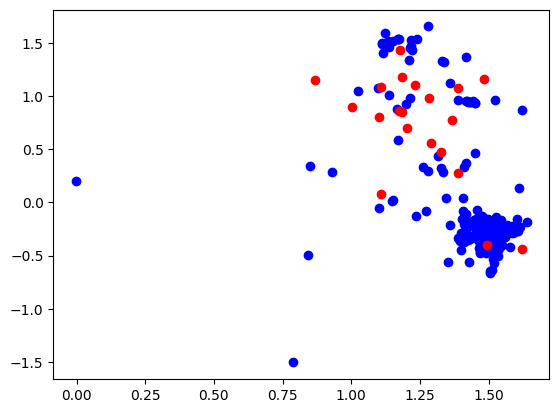

In [17]:
#Bieu dien lop an tap du lieu support data
z_support_normal = z_support[z_support[:, -1]==1]
z_support_anomaly = z_support[z_support[:, -1]==0]
plt.scatter(z_support_normal[:, 0], z_support_normal[:, 1], color = 'b')
plt.scatter(z_support_anomaly[:, 0], z_support_anomaly[:, 1], color = 'r')

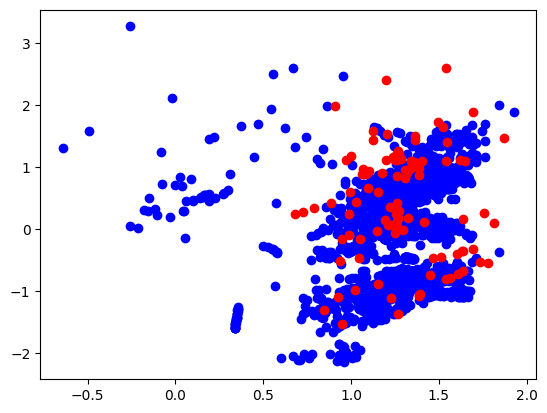

In [18]:
#Bieu dien lop an tap du lieu query data
z_query = np.hstack((z_data_query, label_query[:,np.newaxis]))
z_query_normal = z_query[z_query[:, -1]==1]
z_query_anomaly = z_query[z_query[:, -1]==0]
plt.scatter(z_query_normal[:, 0], z_query_normal[:, 6], color = 'b')
plt.scatter(z_query_anomaly[:, 0], z_query_anomaly[:, 6], color = 'r')

### check concatenate

### Meta testing phase
Support data contain 200 normal and 30 U2R
--> A batch contain selecting 10 normal and selecting 10 U2R samples from supporting data.



In [19]:
# Define input and output dimensions
input_dim = 12
output_dim = 1

# Define the model binary classifier

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=input_dim, activation='tanh', kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
    #tf.keras.layers.Dropout(0.3)
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
print(z_support.shape)
print(label_support.shape)
print(z_query.shape)
print(label_query.shape)



(220, 13)
(220,)
(9610, 13)
(9610,)


In [ ]:
print(z_data_support.shape)

(220, 12)


In [ ]:
np.count_nonzero(label_query[:] == 0)

141

In [26]:
#Create data for training support 


# Define batch size
#batch_size = 20
num_epochs = 20
# Define number of batches per epoch
def create_batch(z_data):
  normal_samples = z_data[z_data[:, -1]==1]
  anomaly_samples = z_data[z_data[:, -1]==0]
  if normal_samples.shape[0] > 0:
    normal_idx = np.random.choice(normal_samples.shape[0], 10, replace=False)
  else: 
    normal_idx = []
  #print(normal_idx)
  if anomaly_samples.shape[0] > 0:
    anomaly_idx = np.random.choice(anomaly_samples.shape[0], 10, replace=False)
  else: 
    anomaly_idx = []
  #print(anomaly_idx)
  # Concatenate normal and anomaly samples to create batch
  batch = np.concatenate([normal_samples[normal_idx], anomaly_samples[anomaly_idx]], axis=0)
  np.random.shuffle(batch)
  return batch


def train_model(model, num_epochs, batch_size, z_support, label_query, z_data_query):
  for epoch in range(num_epochs):
    batch = create_batch(z_support)
    #print(batch.shape)
    
    support_x = batch[:, :-1]
    #print(support_x)
    support_y = batch[:, -1]
    #print(support_y)
    history = model.fit(support_x, support_y, epochs=10, batch_size=20,  \
                        validation_data=(z_data_query, label_query), verbose = 2)
  return model
   
        

In [29]:
import statistics
from sklearn.metrics import roc_auc_score

sum_DR = 0
sum_acc = 0
sum_prec = 0
sum_recall = 0
sum_f1 = 0
accuracy_list=[]
auc_list = []
for i in range(10):
  trained_model = train_model(model, num_epochs=20, batch_size=20, z_support=z_support, 
                            label_query=label_query, z_data_query=z_data_query)
  y_pred_prob = np.argmax(trained_model.predict(z_data_query), axis=-1)
  #print(y_pred_prob)
  auc_score = roc_auc_score(label_query, y_pred_prob)
  auc_list.append(auc_score)
  print("Experiment %d: AUC Score: %0.4f" % (i, auc_score))

print (statistics.mean(auc_list))

'''
  confusion = confusion_matrix(label_query, y_pred_prob)
  tp = confusion[1][1]
  fn = confusion[1][0]
  fp = confusion[0][1]
  tn = confusion[0][0]
  detection_rate = tn*100 / (fp + tn)
  accuracy = (tp+tn)*100 / (tp+fp+fn+tn)
  accuracy_list.append(accuracy)
  precision = tp*100/(tp+fp)
  recall = tp*100/(tp+fn)
  f1_score = 2*(precision * recall) / (precision + recall)
  sum_DR = sum_DR + detection_rate
  sum_acc = sum_acc + accuracy
  sum_prec = sum_prec + precision
  sum_recall = sum_recall + recall 
  sum_f1 = sum_f1 + f1_score
  print (confusion) 
  print("Experiment %d: Number of anomalies sample detectable: %d, the detection rate is: %0.4f" %(i, tn, detection_rate))


avg_DR = sum_DR /10
avg_acc = sum_acc /10
avg_prec = sum_prec /10
avg_recall = sum_recall /10
avg_f1 = sum_f1/10
accuracy_std = np.std(accuracy_list)

print("Ket qua trung binh:") 
print("Detection rate: %0.4f" % avg_DR)
print("Accuracy: %0.4f and the std: %0.4f" % (avg_acc, accuracy_std))
print("precision: %0.4f" %avg_prec)
print("recall: %0.4f" %avg_recall)
print("F1 score: %0.4f" %avg_f1)
'''


Train on 20 samples, validate on 9610 samples
Epoch 1/10
20/20 - 2s - loss: 0.0415 - accuracy: 1.0000 - val_loss: 0.2275 - val_accuracy: 0.9375 - 2s/epoch - 84ms/sample
Epoch 2/10
20/20 - 1s - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.2337 - val_accuracy: 0.9359 - 820ms/epoch - 41ms/sample
Epoch 3/10
20/20 - 1s - loss: 0.0508 - accuracy: 1.0000 - val_loss: 0.2399 - val_accuracy: 0.9348 - 792ms/epoch - 40ms/sample
Epoch 4/10
20/20 - 1s - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.2468 - val_accuracy: 0.9335 - 833ms/epoch - 42ms/sample
Epoch 5/10
20/20 - 1s - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.2533 - val_accuracy: 0.9322 - 950ms/epoch - 47ms/sample
Epoch 6/10
20/20 - 0s - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2601 - val_accuracy: 0.9312 - 436ms/epoch - 22ms/sample
Epoch 7/10
20/20 - 1s - loss: 0.0354 - accuracy: 1.0000 - val_loss: 0.2664 - val_accuracy: 0.9297 - 1s/epoch - 59ms/sample
Epoch 8/10
20/20 - 1s - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.2731 - v

'\n  confusion = confusion_matrix(label_query, y_pred_prob)\n  tp = confusion[1][1]\n  fn = confusion[1][0]\n  fp = confusion[0][1]\n  tn = confusion[0][0]\n  detection_rate = tn*100 / (fp + tn)\n  accuracy = (tp+tn)*100 / (tp+fp+fn+tn)\n  accuracy_list.append(accuracy)\n  precision = tp*100/(tp+fp)\n  recall = tp*100/(tp+fn)\n  f1_score = 2*(precision * recall) / (precision + recall)\n  sum_DR = sum_DR + detection_rate\n  sum_acc = sum_acc + accuracy\n  sum_prec = sum_prec + precision\n  sum_recall = sum_recall + recall \n  sum_f1 = sum_f1 + f1_score\n  print (confusion) \n  print("Experiment %d: Number of anomalies sample detectable: %d, the detection rate is: %0.4f" %(i, tn, detection_rate))\n\n\navg_DR = sum_DR /10\navg_acc = sum_acc /10\navg_prec = sum_prec /10\navg_recall = sum_recall /10\navg_f1 = sum_f1/10\naccuracy_std = np.std(accuracy_list)\n\nprint("Ket qua trung binh:") \nprint("Detection rate: %0.4f" % avg_DR)\nprint("Accuracy: %0.4f and the std: %0.4f" % (avg_acc, accura